In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import time 
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 400)

In [2]:
test_team_data = pd.read_csv('Test_Team Data.csv')
train_team_data = pd.read_csv('Train_Team Data.csv')

In [3]:
train_team_data.head()

,Season,Team,Played,Won,Lost,Tie,Score Difference,Points
0,2018,Gujarat Fortune Giants,22,17,3,2,118,93
1,2018,U Mumba,22,15,5,2,189,86
2,2018,Dabang Delhi,22,11,9,2,-1,68
3,2018,Puneri Paltan,22,8,12,2,-45,52
4,2018,Jaipur Pink Panthers,22,6,13,3,-69,43


In [4]:
test_team_data.head()

,Season,Team,Played,Won,Lost,Tie,Score Difference,Points
0,2019,Dabang Delhi K.C.,18,14,2,2,77,72
1,2019,Bengal Warriors,19,12,4,3,73,86
2,2019,Haryana Steelers,18,11,6,1,60,24
3,2019,Bengaluru Bulls,19,10,8,1,58,12
4,2019,U.P. Yoddha,18,10,6,2,58,-19


###### Make a copy of the test data set to make final predictions

###### We will use past season data (2014 to 2018) as train set to build the model, current season (2019) data as test set for making predictions

In [5]:
test_team_data_final_predictions = test_team_data.copy()

###### Drop columns "Season" and "Score Difference" as they have no bearing on the model

In [6]:
train_team_data.drop(columns = ['Season', 'Score Difference'], inplace = True)
test_team_data.drop(columns = ['Season', 'Score Difference'], inplace = True)

### Start With Task 2: Predict the top team in the points table after the completion of the league matches

###### Train Test Split is not required as we have two seperate data sets

###### Drop column "Team" from training and test dataframes

In [7]:
train_team_data.drop(columns = ['Team'], inplace = True)
test_team_data.drop(columns = ['Team'], inplace = True)

In [8]:
train_team_data.head()

,Played,Won,Lost,Tie,Points
0,22,17,3,2,93
1,22,15,5,2,86
2,22,11,9,2,68
3,22,8,12,2,52
4,22,6,13,3,43


In [9]:
test_team_data.head()

,Played,Won,Lost,Tie,Points
0,18,14,2,2,72
1,19,12,4,3,86
2,18,11,6,1,24
3,19,10,8,1,12
4,18,10,6,2,-19


In [10]:
test_team_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
Played    12 non-null int64
Won       12 non-null int64
Lost      12 non-null int64
Tie       12 non-null int64
Points    12 non-null int64
dtypes: int64(5)
memory usage: 560.0 bytes


In [11]:
train_team_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
Played    72 non-null int64
Won       72 non-null int64
Lost      72 non-null int64
Tie       72 non-null int64
Points    72 non-null int64
dtypes: int64(5)
memory usage: 2.9 KB


###### Rescale Features using Min Max Scaler

In [12]:
scaler = MinMaxScaler()
num_vars = ['Played', 'Won', 'Lost', 'Tie', 'Points']
train_team_data[num_vars] = scaler.fit_transform(train_team_data[num_vars])

train_team_data.head()

,Played,Won,Lost,Tie,Points
0,1.0,1.000000,0.1875,0.333333,1.000000
1,1.0,0.882353,0.3125,0.333333,0.924731
2,1.0,0.647059,0.5625,0.333333,0.731183
3,1.0,0.470588,0.7500,0.333333,0.559140
4,1.0,0.352941,0.8125,0.500000,0.462366


###### Divide into X & Y. Y = 'Points' (Column to be predicted)

In [13]:
y_train = train_team_data.pop('Points')
X_train = train_team_data

In [14]:
y_train.head()

0    1.000000
1    0.924731
2    0.731183
3    0.559140
4    0.462366
Name: Points, dtype: float64

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
Played    72 non-null float64
Won       72 non-null float64
Lost      72 non-null float64
Tie       72 non-null float64
dtypes: float64(4)
memory usage: 2.3 KB


In [16]:
X_train.head()

,Played,Won,Lost,Tie
0,1.0,1.000000,0.1875,0.333333
1,1.0,0.882353,0.3125,0.333333
2,1.0,0.647059,0.5625,0.333333
3,1.0,0.470588,0.7500,0.333333
4,1.0,0.352941,0.8125,0.500000


###### Model Selection using RFE 

In [17]:
# Running RFE with the output number of the variable equal to 4
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 4)
rfe = rfe.fit(X_train, y_train)

In [18]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Played', True, 1), ('Won', True, 1), ('Lost', True, 1), ('Tie', True, 1)]

In [19]:
col = X_train.columns[rfe.support_]
col

Index(['Played', 'Won', 'Lost', 'Tie'], dtype='object')

In [20]:
X_train.columns[~rfe.support_]

Index([], dtype='object')

###### Building model using statsmodel, for the detailed statistics

In [21]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [22]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

In [23]:
# Run the linear model
lm = sm.OLS(y_train,X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     8411.
Date:                Sun, 29 Sep 2019   Prob (F-statistic):           2.64e-87
Time:                        11:11:25   Log-Likelihood:                 202.66
No. Observations:                  72   AIC:                            -397.3
Df Residuals:                      68   BIC:                            -388.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.428      0.6

In [24]:
X_train_new = X_train_rfe.drop(['const'], axis=1)

In [25]:
# Calculate the VIFs for the new model

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,Played,inf
1,Won,inf
2,Lost,inf
3,Tie,inf


###### As all variables are significant and highly collinear, we will first drop the variable "Played" 

In [26]:
# Drop the column "Super Raids" with highest P-Value 0.442 and VIF: 10.60
X_train_new = X_train_new.drop(["Played"], axis = 1)

In [27]:
# Run the linear model
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     8411.
Date:                Sun, 29 Sep 2019   Prob (F-statistic):           2.64e-87
Time:                        11:11:25   Log-Likelihood:                 202.66
No. Observations:                  72   AIC:                            -397.3
Df Residuals:                      68   BIC:                            -388.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.428      0.6

In [28]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,Won,2.93
2,Tie,2.73
1,Lost,2.50


###### We now derive an initial linear model with R-Squared: 0.997, adjusted R-Squared: 0.997, F-Statistic Probability practically 0, AIC: -397 & BIC: -388. All features are significant ( <0.05 ) and VIF < 3

###### The equation of the initial linear model is Points = ( 0 + [ (0.92 * Won ] + [ (0.08) * Lost ]  + [0.21 * (Tie) ] ) 

###### Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [29]:
y_train_points = lm.predict(X_train_lm)

Text(0.5, 0, 'Errors')

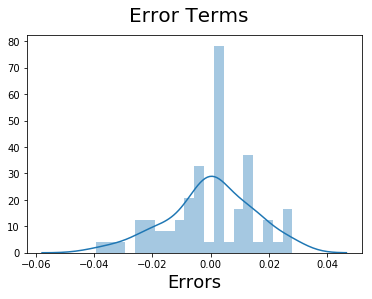

In [30]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_points), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

###### Error terms are normally distributed with mean centered around 0. We now proceed with 

###### We will now proceed with making predictions on the test dataset

In [31]:
num_vars = ['Played', 'Won', 'Lost', 'Tie', 'Points']

test_team_data[num_vars] = scaler.transform(test_team_data[num_vars])
test_team_data.head()

,Played,Won,Lost,Tie,Points
0,0.818182,0.823529,0.125,0.333333,0.774194
1,0.863636,0.705882,0.250,0.500000,0.924731
2,0.818182,0.647059,0.375,0.166667,0.258065
3,0.863636,0.588235,0.500,0.166667,0.129032
4,0.818182,0.588235,0.375,0.333333,-0.204301


In [32]:
y_test = test_team_data.pop('Points')
X_test = test_team_data

In [33]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [34]:
y_pred = lm.predict(X_test_new)

In [35]:
y_pred.head()

0    0.839884
1    0.775616
2    0.663034
3    0.618969
4    0.642831
dtype: float64

In [36]:
y_pred.count()

12

Text(0, 0.5, 'y_pred')

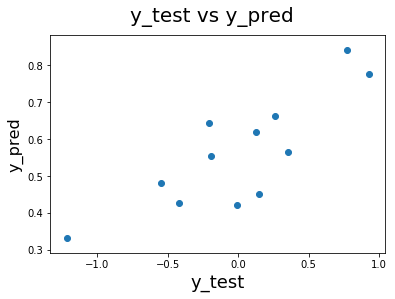

In [37]:
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

###### Our Final Equation will be: Points = ( 0 + [ (0.92 * Won ] + [ (0.08) * Lost ]  + [0.21 * (Tie) ] ) 

In [38]:
test_team_data_final_predictions.head()

,Season,Team,Played,Won,Lost,Tie,Score Difference,Points
0,2019,Dabang Delhi K.C.,18,14,2,2,77,72
1,2019,Bengal Warriors,19,12,4,3,73,86
2,2019,Haryana Steelers,18,11,6,1,60,24
3,2019,Bengaluru Bulls,19,10,8,1,58,12
4,2019,U.P. Yoddha,18,10,6,2,58,-19


In [39]:
test_team_data.head()

,Played,Won,Lost,Tie
0,0.818182,0.823529,0.125,0.333333
1,0.863636,0.705882,0.250,0.500000
2,0.818182,0.647059,0.375,0.166667
3,0.863636,0.588235,0.500,0.166667
4,0.818182,0.588235,0.375,0.333333


In [40]:
test_team_data_final_predictions.drop(columns = ['Points'], inplace = True)

In [41]:
test_team_data_final_predictions.head()

,Season,Team,Played,Won,Lost,Tie,Score Difference
0,2019,Dabang Delhi K.C.,18,14,2,2,77
1,2019,Bengal Warriors,19,12,4,3,73
2,2019,Haryana Steelers,18,11,6,1,60
3,2019,Bengaluru Bulls,19,10,8,1,58
4,2019,U.P. Yoddha,18,10,6,2,58


In [42]:
test_team_data_final_predictions['Points'] = (
    0 
    + (0.92 * test_team_data_final_predictions['Won']) 
    + (0.08 * test_team_data_final_predictions['Lost']) 
    + (0.21 * test_team_data_final_predictions['Tie'])
)

In [43]:
test_team_data_final_predictions

,Season,Team,Played,Won,Lost,Tie,Score Difference,Points
0,2019,Dabang Delhi K.C.,18,14,2,2,77,13.46
1,2019,Bengal Warriors,19,12,4,3,73,11.99
2,2019,Haryana Steelers,18,11,6,1,60,10.81
3,2019,Bengaluru Bulls,19,10,8,1,58,10.05
4,2019,U.P. Yoddha,18,10,6,2,58,10.10
5,2019,U Mumba,18,9,8,1,54,9.13
6,2019,Jaipur Pink Panthers,20,8,10,2,52,8.58
7,2019,Gujarat Fortune Giants,19,6,11,2,44,6.82
8,2019,Puneri Paltan,19,6,10,3,42,6.95
9,2019,Patna Pirates,19,6,12,1,40,6.69


In [44]:
test_team_data_final_predictions['Points'] = test_team_data_final_predictions['Points'].astype('int64')

In [45]:
test_team_data_final_predictions[['Team', 'Points']].sort_values(by='Points', ascending=False).head(4)

,Team,Points
0,Dabang Delhi K.C.,13
1,Bengal Warriors,11
2,Haryana Steelers,10
3,Bengaluru Bulls,10


###### Top 4 Teams

In [46]:
test_team_data_final_predictions['Team'].head(6)

0    Dabang Delhi K.C.
1      Bengal Warriors
2     Haryana Steelers
3      Bengaluru Bulls
4          U.P. Yoddha
5              U Mumba
Name: Team, dtype: object

### Final prediction: DABANG DELHI will top the points chart.